In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import networkx as nx
import torch
import matplotlib.pyplot as plt

from model_helper import CARPE_ECG_model, CARPE_Clin_model

## Load sample data
In this cell we will load sample data (three samples) from the publicly accessible ECG data set Zheng. et al. [A 12-lead electrocardiogram database for arrhythmia research covering more than 10,000 patients](https://figshare.com/collections/ChapmanECG/4560497/2). Note that this data is only used to show the general functionalities of the code. We don't expect the predictions to be reasonable as they do not comply to the 2-6-2 format we used in the manuscript. We will also make up the small set of static data.

In [2]:
# Load sample ECG data for 3 "patients".
with open("../data/sample.pkl", "rb") as f:
    v6_ecg_data = pickle.load(f)

# Make up some static features including the ground truth "CAD" label.
samples_clin = [
    {"ID": "Pat_3", "cad_label": 1, "age": 32.0, "sex": 2., "height": 167., "rest_hr": 68., "weight": 66., "rest_systolic_BP": 118., "rest_diastolic_BP": 70., "cad_history": 0.},
    {"ID": "Pat_1", "cad_label": 1, "age": 71.0, "sex": 1., "height": 177., "rest_hr": 90., "weight": 75., "rest_systolic_BP": 135., "rest_diastolic_BP": 90., "cad_history": 1.},
    {"ID": "Pat_2", "cad_label": 0, "age": 44.0, "sex": 1., "height": 182., "rest_hr": 70., "weight": 72., "rest_systolic_BP": 122., "rest_diastolic_BP": 91., "cad_history": 1.},
]
samples_clin = pd.DataFrame(samples_clin).set_index("ID")
clin_data = samples_clin.values[:, 1:]
labels = samples_clin.cad_label.values
pat_ids = samples_clin.index.values

# 3 Patients, 5000 ECG measurements, 8 static features
sample_data = np.concatenate([v6_ecg_data, clin_data], axis=1)

## Show clinical features of patients

In [3]:
samples_clin

,cad_label,age,sex,height,rest_hr,weight,rest_systolic_BP,rest_diastolic_BP,cad_history
ID,,,,,,,,,
Pat_3,1,32.0,2.0,167.0,68.0,66.0,118.0,70.0,0.0
Pat_1,1,71.0,1.0,177.0,90.0,75.0,135.0,90.0,1.0
Pat_2,0,44.0,1.0,182.0,70.0,72.0,122.0,91.0,1.0


## Show sample ECG data for sample patients

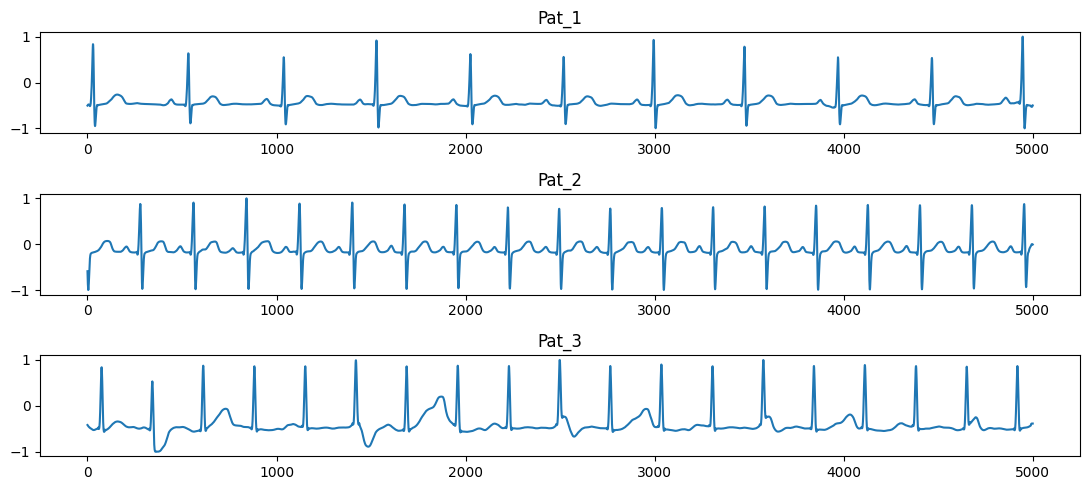

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(11, 5))

axes[0].plot(v6_ecg_data[0])
axes[1].plot(v6_ecg_data[1])
axes[2].plot(v6_ecg_data[2])

axes[0].set_title("Pat_1")
axes[1].set_title("Pat_2")
axes[2].set_title("Pat_3")

plt.tight_layout()

## Load CARPE_ECG and CARPE_Clin from all five splits and generate predictions

In [5]:
all_preds_ecg = []
all_preds_clin = []
# Iterate over the checkpoints from all five splits
for split in tqdm([0, 1, 2, 3, 4]):
    # Load CARPE_ECG checkpoint
    ecg_model = CARPE_ECG_model(split)
    
    # Create predictions
    model_preds = []
    preds = ecg_model.predict(sample_data)
    model_preds.append(preds.numpy())
    df_ecg = pd.DataFrame({'split': split,
                           'preds': np.concatenate(model_preds).reshape(-1),
                           'ID': pat_ids,
                           'label': labels})
    all_preds_ecg.append(df_ecg)

    # Load CARPE_Clin. model
    clin_model = CARPE_Clin_model(split)
    
    # Create predictions
    preds = clin_model.predict(clin_data)
    df_clin = pd.DataFrame({'split': split,
                            'preds': preds[:, 1],
                            'ID': pat_ids,
                            'label': labels})
    all_preds_clin.append(df_clin)
    
# Compute average scores
combined_preds_ecg = pd.concat(all_preds_ecg)
combined_preds_ecg = combined_preds_ecg.groupby('ID').mean()
combined_preds_ecg.loc[:, 'method'] = 'CARPE_ECG'

combined_preds_clin = pd.concat(all_preds_clin)
combined_preds_clin = combined_preds_clin.groupby('ID').mean()
combined_preds_clin.loc[:, 'method'] = 'CARPE_Clin'

combined_preds = pd.concat((combined_preds_ecg, combined_preds_clin))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.86it/s]


## Visualize the multi-task architecture
This is a visualization of [TorchMTL](https://github.com/chrisby/torchMTL)'s meta-computation graph. 
From the root node, we select the ECG time series (`selectTS`) and send it through the ResNet. simultaneously, we collect the clinical features (`selectClin`) and send it through the respective neural network. The outputs of both layers are combined (`CombLayer`) and used to predict the auxiliary tasks and the main task (`EIMIPred`).
Note, EIMI stands for **E**xercised **I**nduced **M**yocardial **I**schaemia.

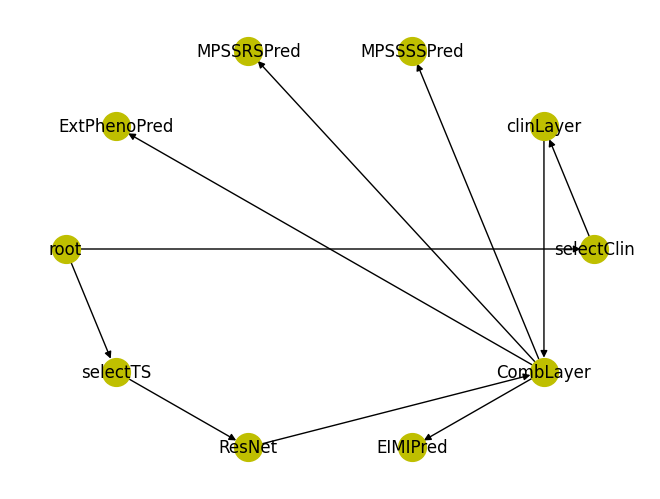

In [6]:
pos = nx.shell_layout(ecg_model.mtl_model.g)
nx.draw(ecg_model.mtl_model.g, pos, font_size=12, node_color="y", node_size=400, with_labels=True)

## Show prediction results

In [7]:
combined_preds = pd.concat((combined_preds_ecg, combined_preds_clin))
combined_preds.rename(columns={'method': 'Method',
                              'preds': 'Predicted Score', 
                              'label': 'Presence of CAD (Ground Truth)'}, inplace=True)
# Map numeric values to bools
cad_map = {0.0: False, 1.0: True}
combined_preds['Presence of CAD (Ground Truth)'] = combined_preds['Presence of CAD (Ground Truth)'].map(cad_map)
combined_preds[['Method', 'Predicted Score', 'Presence of CAD (Ground Truth)']].sort_values(by=['ID', 'Method'])

,Method,Predicted Score,Presence of CAD (Ground Truth)
ID,,,
Pat_1,CARPE_Clin,0.575506,True
Pat_1,CARPE_ECG,0.142264,True
Pat_2,CARPE_Clin,0.537866,False
Pat_2,CARPE_ECG,0.553541,False
Pat_3,CARPE_Clin,0.170697,True
Pat_3,CARPE_ECG,0.290141,True
